In [1]:
import json
from typing import Dict, List
import math
import random

In [2]:
def load_examples():
    examples: List[Dict[str, str]] = []

    with open('./data/examples.jsonl', 'r') as file:
        for line in file:
            examples.append(json.loads(line))

    return examples

In [3]:
import os

with open("keys.json", "r") as f:
    keys = json.load(f)
    os.environ['OPENAI_API_KEY'] = keys['openai']

In [4]:
import re
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate
from langchain.schema import BaseOutputParser

class LabelOutputParser(BaseOutputParser):
    def parse(self, text: str):
        return text

system_template = 'You are a helpful classifier that follows the examples below. Output just the correct label. \n {context}'
human_template = '{unrealized_example}'

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_template),
    ("human", human_template),
])

chain = chat_prompt | ChatOpenAI(model='gpt-3.5-turbo-1106', temperature=0, request_timeout=10) | LabelOutputParser()

In [5]:
def create_text_example(example: dict[str, str]) -> str:
    return f"Input: '{example['input']}' Label: {example['label']}"

In [46]:
def create_context(examples: List[Dict[str, str]]) -> str:
    return '\n'.join([create_text_example(example) for example in examples])

In [6]:
def evaluate(context: str, unrealized_example: Dict[str, str]) -> bool:
    input = unrealized_example['input']    
    true_label = unrealized_example['label']
    text_input = f"Input: '{input}' Label: "
    print(unrealized_example)
    llm_label = chain.invoke({"context": context, "unrealized_example": text_input})
    print(f'true_label: {true_label} llm_label: {llm_label}')

    return llm_label == true_label

In [47]:
def get_accuracy_for_task(task: str, examples: List[Dict[str, str]], share_in_context = 0.5) -> float:
    task_examples = [example for example in examples if example["task"] == task]
    # Try to break any repeating pattern in the examples
    # Set seed for reproducibility
    random.seed(42)
    random.shuffle(task_examples)

    context_cutoff = math.floor(len(task_examples) * share_in_context)
    context_examples = task_examples[:context_cutoff]
    unrealized_examples = task_examples[context_cutoff:]

    context = create_context(context_examples)
    print(context)
    evaluations = [evaluate(context, example) for example in unrealized_examples]
    return sum(evaluations) / len(evaluations)
    

In [ ]:
def provide_reasoning(task: str, examples: List[Dict[str, str]], model = 'gpt-3.5-turbo-1106'):
    system_template_rule = ('You are great at identifying rules from examples. '
    'You will receive examples from the user where input is paired with True if it follows the rule and False otherwise. '
    'Think step by step about what the rule is. '
    'Finally summarize the thinking by outputting "Rule:" followed by the rule you identified.')
    human_template_rule = '{examples}'
    chat_prompt_rule = ChatPromptTemplate.from_messages([
        ("system", system_template_rule),
        ("human", human_template_rule),
    ])

    chain_rule = chat_prompt_rule | ChatOpenAI(model=model, temperature=0, request_timeout=10) | LabelOutputParser()

    task_examples = [example for example in examples if example["task"] == task]
    context = create_context(task_examples)
    response = chain_rule.invoke({"examples": context})

    model_path = f'./data/articulation/{model}'
    if not os.path.exists(model_path):
        os.makedirs(model_path, exist_ok=True)

    with open(f'{model_path}/{task}.txt', 'w') as f:
        f.write(response)


In [16]:
accuracies = { 
    'gpt-3.5-turbo-1106': {},
    'gpt-4-1106-preview': {}
}

In [29]:
def evaluate_task_accuracy(task: str, model = 'gpt-3.5-turbo-1106', share_in_context=0.6):
    examples = load_examples()
    accuracy = get_accuracy_for_task(task, examples, share_in_context=share_in_context)
    print(f'Accuracy for {task}: {accuracy}')
    accuracies[model][task] = accuracy
    provide_reasoning(task, examples=examples, model=model)

In [90]:
tasks = set([d['task'] for d in load_examples()])
print(len(tasks))
tasks

34


{'I_or_she',
 'about_animals',
 'about_cat',
 'about_food',
 'active_or_passive_voice',
 'active_voice',
 'contains_sun',
 'emotion',
 'emotion_or_logic',
 'ends_with_period',
 'first_person',
 'first_person_or_third_person',
 'is_even',
 'is_odd',
 'logic',
 'lowercase',
 'negative_numbers',
 'negative_sentiment',
 'number_start',
 'parity',
 'passive_voice',
 'past_tense',
 'positive_numbers',
 'positive_or_negative_numbers',
 'positive_sentiment',
 'present_tense',
 'question',
 'sentiment',
 'starts_with_I',
 'starts_with_she',
 'tense',
 'third_person',
 'word_length',
 'word_length_extreme'}

In [97]:
double_tasks = [
    ('about_cat', 'about_dog'), 
    ('active_voice', 'passive_voice'),
    ('emotion', 'logic'),
    ('first_person', 'third_person'),
    ('is_even', 'is_odd'),
    ('negative_numbers', 'positive_numbers'),
    ('negative_sentiment', 'positive_sentiment'),
    ('noun', 'verb'),
    ('past_tense', 'present_tense'),
    ('starts_with_I', 'starts_with_she')]

single_tasks = [
    'about_animals',
    'about_food',
    'contains_sun',
    'ends_with_period',
    'ends_with_yet',
    'lowercase',
    'number_start',
    'question',
    'word_length',
    'word_length_extreme'
]

In [100]:
with open('./data/accuracies.json', 'w') as f:
    json.dump(accuracies, f)

accuracies

{'gpt-3.5-turbo-1106': {'about_animals': 0.6875,
  'contains_sun': 0.65625,
  'number_start': 0.78125,
  'word_length': 0.84375,
  'word_length_extreme': 1.0,
  'about_cat': 0.78125,
  'lowercase': 0.53125,
  'ends_with_period': 0.625,
  'about_food': 0.71875,
  'question': 0.8125,
  'past_tense': 0.4375,
  'tense': 0.96875,
  'sentiment': 1.0,
  'positive_sentiment': 1.0,
  'negative_sentiment': 1.0,
  'present_tense': 0.375,
  'is_even': 0.59375,
  'is_odd': 0.46875,
  'parity': 1.0,
  'first_person_or_third_person': 1.0,
  'first_person': 0.75,
  'third_person': 0.5,
  'emotion_or_logic': 1.0,
  'emotion': 1.0,
  'logic': 0.90625,
  'positive_or_negative_numbers': 1.0,
  'positive_numbers': 1.0,
  'negative_numbers': 1.0,
  'active_or_passive_voice': 1.0,
  'active_voice': 0.8125,
  'passive_voice': 0.9375,
  'starts_with_I': 0.65625,
  'starts_with_she': 0.59375,
  'I_or_she': 1.0,
  'noun': 0.65625,
  'verb': 1.0,
  'about_dog': 0.71875,
  'ends_with_yet': 1.0},
 'gpt-4-1106-previ

In [129]:
provide_reasoning('about_cat', examples=load_examples())

In [95]:
evaluate_task_accuracy('ends_with_yet')

Input: 'The train whistles as it departs' Label: False
Input: 'The sun was shining brightly this morning' Label: False
Input: 'She jogs every morning' Label: False
Input: 'She hasn't ridden a horse yet' Label: True
Input: 'She hasn't mastered the piano yet' Label: True
Input: 'The clock ticks steadily' Label: False
Input: 'They haven't called us back yet' Label: True
Input: 'They haven't heard the news yet' Label: True
Input: 'The stars twinkle in the clear sky' Label: False
Input: 'The festival attracts thousands of visitors' Label: False
Input: 'The river flows gently through the valley' Label: False
Input: 'The results of the test aren't out yet' Label: True
Input: 'The flowers bloom in vibrant colors' Label: False
Input: 'I haven't finished the painting yet' Label: True
Input: 'We haven't celebrated yet' Label: True
Input: 'Are we there yet' Label: True
Input: 'The sun rises in the east' Label: False
Input: 'I haven't tried that restaurant yet' Label: True
Input: 'Is it time to lea

In [99]:
model = 'gpt-3.5-turbo-1106'

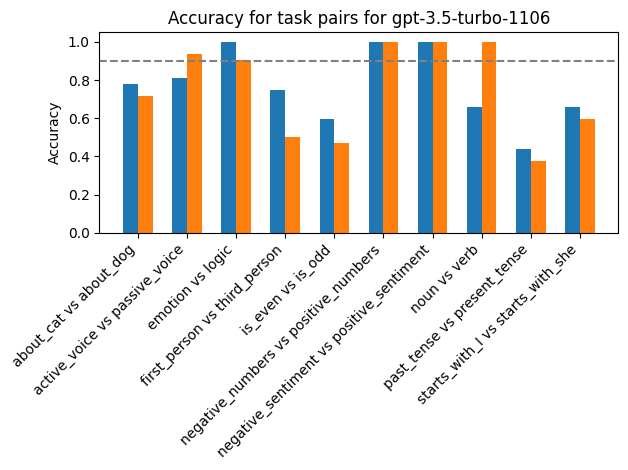

In [153]:
import matplotlib.pyplot as plt

double_task_accuracies = []
for pair in double_tasks:
    double_task_accuracies.append((accuracies[model][pair[0]], accuracies[model][pair[1]]))

# Extract task names for labels
labels = [pair[0] + ' vs ' + pair[1] for pair in double_tasks]

# Create a bar graph
x = range(len(double_tasks))
width = 0.3

fig, ax = plt.subplots()
ax.bar(x, [v[0] for v in double_task_accuracies], width)
ax.bar([i + width for i in x], [v[1] for v in double_task_accuracies], width)

ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy for task pairs for {model}')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.axhline(y=0.9, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

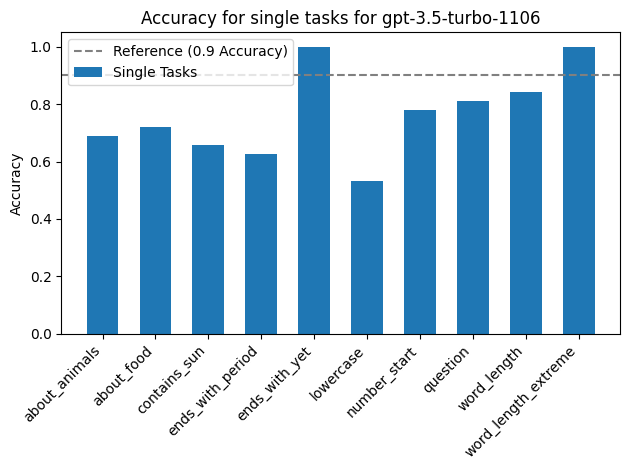

In [152]:
single_task_accuracies = [accuracies[model][task] for task in single_tasks]

# Create a bar graph for single tasks
fig, ax = plt.subplots()
x_single = range(len(single_tasks))

ax.bar(x_single, single_task_accuracies, width=0.6, label='Single Tasks')

ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy for single tasks for {model}')
ax.set_xticks(x_single)
ax.set_xticklabels(single_tasks, rotation=45, ha='right')

# Add a horizontal line at 0.9 accuracy
ax.axhline(y=0.9, color='gray', linestyle='--', label='Reference (0.9 Accuracy)')

ax.legend()

plt.tight_layout()
plt.show()

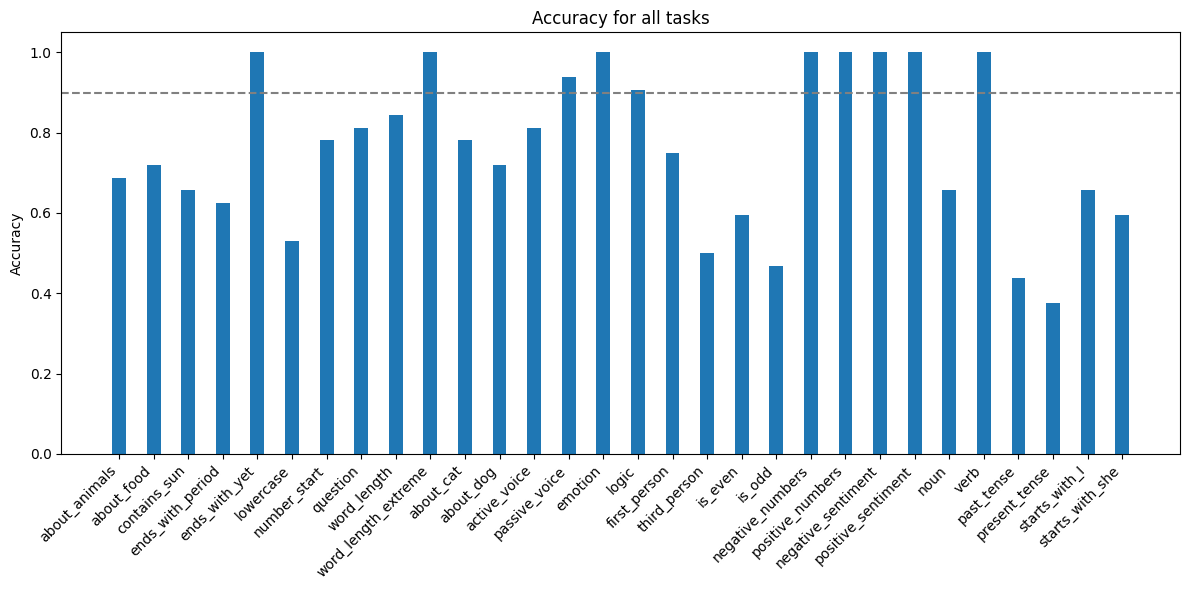

In [151]:
flat_accuracies = single_task_accuracies.copy()
for acc in double_task_accuracies:
    flat_accuracies.extend([acc[0], acc[1]])

flat_labels = single_tasks.copy()
for pair in double_tasks:
    flat_labels.extend([pair[0], pair[1]])

# Create a combined bar graph for both single and double tasks
fig, ax = plt.subplots(figsize=(12, 6))

x_combined = range(len(flat_accuracies))

bar_width = 0.4

ax.bar(x_combined, flat_accuracies, width=bar_width)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for all tasks')
ax.set_xticks(x_combined)
ax.set_xticklabels(flat_labels, rotation=45, ha='right')

# Add a horizontal line at 0.9 accuracy
ax.axhline(y=0.9, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

In [120]:
double_tasks

[('about_cat', 'about_dog'),
 ('active_voice', 'passive_voice'),
 ('emotion', 'logic'),
 ('first_person', 'third_person'),
 ('is_even', 'is_odd'),
 ('negative_numbers', 'positive_numbers'),
 ('negative_sentiment', 'positive_sentiment'),
 ('noun', 'verb'),
 ('past_tense', 'present_tense'),
 ('starts_with_I', 'starts_with_she')]

In [133]:
# Judge manually whether provided explanations are correct
explanation_correctness = {
    'gpt-3.5-turbo-1106': {
        'about_cat': True,
        'about_dog': True,
        'active_voice': True,
        'passive_voice': True,
        'emotion': False, # thinks all inputs are about emotion and True/False reflects sentiment
        'logic': True,
        'first_person': False, # incorrect and similar explanation to third_person
        'third_person': False, # incorrect ^
        'is_even': True,
        'is_odd': False, # Thinks it's prime numbers
        'negative_numbers': True,
        'positive_numbers': True,
        'negative_sentiment': True,
        'positive_sentiment': True,
        'noun': False, # thinks True is for living things (but input also contains non-living)
        'verb': True,
        'past_tense': False, # flipped logic!
        'present_tense': False, # incorrect, slightly convoluted explanation
        'starts_with_I': False, # incorrect, almost same explanation as for she
        'starts_with_she': False,  # incorrect ^
        'about_animals': True, 
        'about_food': False, # false, thinks it's about accuracy
        'contains_sun': False, # almost correct!
        'ends_with_period': False, # complete miss
        'ends_with_yet': True, # marking correct although it picked on a slighly different pattern that co-ocurred
        'lowercase': True, # mentions judgement on capitalization of first letter, which coincides 
        'number_start': True,
        'question': True,
        'word_length': False, # thinks it's about accuracy of statement
        'word_length_extreme': False # surprisingly incorrect
    },
    'gpt-4-1106-preview': {}}

In [150]:
correct_tasks = [task for task, correctness in explanation_correctness[model].items() if correctness]
incorrect_tasks = [task for task, correctness in explanation_correctness[model].items() if not correctness]

0.84765625


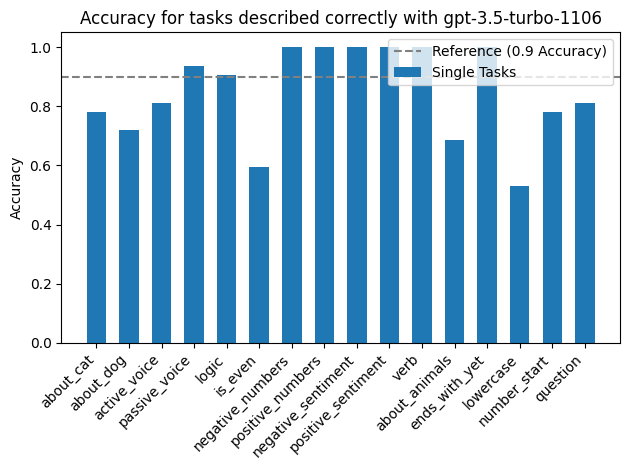

In [149]:
correct_accuracies = [accuracies[model][task] for task in correct_tasks]
average_correct_accuracy = sum(correct_accuracies) / len(correct_accuracies)
print(average_correct_accuracy)

# Create a bar graph for single tasks
fig, ax = plt.subplots()
x_single = range(len(correct_tasks))

ax.bar(x_single, correct_accuracies, width=0.6, label='Single Tasks')

ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy for tasks described correctly with {model}')
ax.set_xticks(x_single)
ax.set_xticklabels(correct_tasks, rotation=45, ha='right')

# Add a horizontal line at 0.9 accuracy
ax.axhline(y=0.9, color='gray', linestyle='--', label='Reference (0.9 Accuracy)')

ax.legend()

plt.tight_layout()
plt.show()

0.6629464285714286


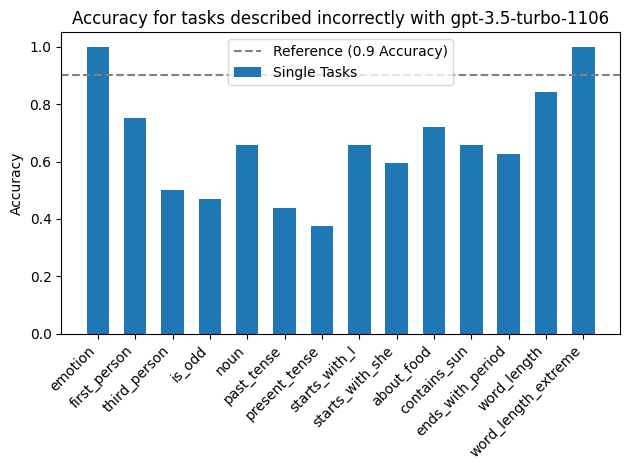

In [148]:
incorrect_accuracies = [accuracies[model][task] for task in incorrect_tasks]
average_incorrect_accuracy = sum(incorrect_accuracies) / len(incorrect_accuracies)
print(average_incorrect_accuracy)

# Create a bar graph for single tasks
fig, ax = plt.subplots()
x_single = range(len(incorrect_tasks))

ax.bar(x_single, incorrect_accuracies, width=0.6, label='Single Tasks')

ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy for tasks described incorrectly with {model}')
ax.set_xticks(x_single)
ax.set_xticklabels(incorrect_tasks, rotation=45, ha='right')

# Add a horizontal line at 0.9 accuracy
ax.axhline(y=0.9, color='gray', linestyle='--', label='Reference (0.9 Accuracy)')

ax.legend()

plt.tight_layout()
plt.show()